In [1]:
!pip install gdown
!pip install pycountry
!pip install geonamescache
!pip install unidecode
!pip install catboost

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.3/6.3 MB 31.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 26.6/26.6 MB 50.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 235.8/235.8 kB 4.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 99.2/99.2 MB 8.4 MB/s eta 0:00:00


In [2]:
import gdown
import ast
import pycountry
import shap
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import xgboost as xgb
from geonamescache import GeonamesCache
from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import BallTree
from unidecode import unidecode
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import GradientBoostingRegressor
from xgboost import XGBRegressor
from lightgbm import LGBMRegressor
from catboost import CatBoostRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error, mean_absolute_percentage_error, r2_score
from sklearn.linear_model import RidgeCV
from sklearn.linear_model import Ridge
from dataclasses import dataclass
from hyperopt import hp, fmin, tpe, STATUS_OK, Trials
import json
import warnings
warnings.filterwarnings('ignore')

# Dataset

## Downloading the datasets

In [ ]:
# file_id = '1-0AmnXLGk1FI49_ChB9942W2Z1dUNL7D'
# url = f'https://drive.google.com/uc?id={file_id}'

# gdown.download(url, 'df.csv', quiet=False)

# df = pd.read_csv('df.csv')

In [ ]:
# file_id = '1-07rfiN_6wwQhdRYdtw20fdkGleKGikw'
# url = f'https://drive.google.com/uc?id={file_id}'

# gdown.download(url, 'tenders.csv', quiet=False)

# df_tenders = pd.read_csv('tenders.csv')

In [3]:
df = pd.read_csv('/content/drive/MyDrive/diploma/Output datasets/df.csv')

In [4]:
df_tenders = pd.read_csv('/content/drive/MyDrive/diploma/Output datasets/df_tenders.csv')

In [5]:
print(df.shape)
df.head()

(28427, 24)


,id,date,country_from,city_from,zip_from,country_to,city_to,zip_to,validated_transport_type,distance_km,...,lon_to,eur_km,population_from,population_to,population_from_source,population_to_source,GDP_from,GDP_to,diesel_price_country_from,diesel_price_country_to
0,93273,2021-09-02,CZ,dobrenice,503 25,UA,stoyanka,08114,semi trailer - jumbo,1270.0,...,30.226521,1.220472,90596.0,65167.0,geo,geo,290.973,199.868,1244.600000,1374.427239
1,93249,2021-09-02,GB,flint,CH6,UA,stoyanka,08114,semi trailer - tautliner - standard,2800.0,...,30.226521,0.946429,26442.0,65167.0,matched,geo,3144.079,199.868,1374.427239,1374.427239
2,93250,2021-09-02,GB,chorley,PR7 2RX,UA,stoyanka,08114,semi trailer - tautliner - standard,2900.0,...,30.226521,0.896552,33888.0,65167.0,matched,geo,3144.079,199.868,1374.427239,1374.427239
3,93251,2021-09-02,GB,chorley,PR7 2RX,UA,stoyanka,08114,semi trailer - tautliner - standard,2900.0,...,30.226521,0.931034,33888.0,65167.0,matched,geo,3144.079,199.868,1374.427239,1374.427239
4,93252,2021-09-02,GB,chorley,PR7 2RX,UA,stoyanka,08114,semi trailer - tautliner - standard,2900.0,...,30.226521,0.879310,33888.0,65167.0,matched,geo,3144.079,199.868,1374.427239,1374.427239


In [6]:
print(df.columns)
df.info()

Index(['id', 'date', 'country_from', 'city_from', 'zip_from', 'country_to',
       'city_to', 'zip_to', 'validated_transport_type', 'distance_km', 'price',
       'lat_from', 'lon_from', 'lat_to', 'lon_to', 'eur_km', 'population_from',
       'population_to', 'population_from_source', 'population_to_source',
       'GDP_from', 'GDP_to', 'diesel_price_country_from',
       'diesel_price_country_to'],
      dtype='object')
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 28427 entries, 0 to 28426
Data columns (total 24 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   id                         28427 non-null  object 
 1   date                       28427 non-null  object 
 2   country_from               28427 non-null  object 
 3   city_from                  28427 non-null  object 
 4   zip_from                   28427 non-null  object 
 5   country_to                 28427 non-null  object 
 6   city_to      

In [7]:
# Pull your raw strings, cast everything to str, strip whitespace
raw = df['date'].astype(str).str.strip()

# Drop any time‐of‐day if present (e.g. "2021-09-02 00:00:00" → "2021-09-02")
raw = raw.str.split().str[0]

# Normalize separators so that "." and "/" become "-"
raw = raw.str.replace(r'[\.\/]', '-', regex=True)

# Fix any odd “YYYY-DDMM” blobs like "2024-2112" → "2024-21-12"
raw = raw.str.replace(r'^(\d{4})-(\d{2})(\d{2})$', r'\1-\2-\3', regex=True)

# Now parse strictly as ISO dates
df['date'] = pd.to_datetime(
    raw,
    format='%Y-%m-%d',
    dayfirst=False,
    infer_datetime_format=True,
    errors='coerce'
)

# Check how many still failed
n_bad = df['date'].isna().sum()
print(f"Still-unparsed rows: {n_bad} / {len(df)}")

# # Finally: fill any NaT so you end up with zero nulls.
# #    Here we do a forward-then-backward fill in the order of the DataFrame—
# #    you can also group by route or country if that makes more sense.
# df['date'] = df['date'].ffill().bfill()

# # Verify
# print(df['date'].isna().sum(), df['date'].dtype)

Still-unparsed rows: 0 / 28427


In [8]:
# df['date'] = pd.to_datetime(df['date'].str.strip(), errors='coerce', utc=False)

In [9]:
print(df_tenders.shape)
df_tenders.head()

(1299, 25)


,id,date,validated_transport_type,distance_km,status,lat_from,lon_from,lat_to,lon_to,city_from,...,price,eur_km,population_from,population_to,population_from_source,population_to_source,GDP_from,GDP_to,diesel_price_country_from,diesel_price_country_to
0,34374,2018-12-29 23:00:00,semi trailer - tautliner - standard,1100.0,Win,52.311963,17.046914,50.450360,30.524503,gadki,...,1500.0,1.363636,26431.0,2797553.0,geo,matched,588.804,130.959,1173.77,1285.439355
1,34376,2018-12-29 23:00:00,semi trailer - tautliner - standard,4950.0,Win,52.311963,17.046914,41.299496,69.240073,gadki,...,5475.0,1.106061,26431.0,1978028.0,geo,matched,588.804,58.696,1173.77,1285.439355
2,34377,2018-12-29 23:00:00,semi trailer - tautliner - standard,3700.0,Win,52.311963,17.046914,40.409262,49.867092,gadki,...,3730.0,1.008108,26431.0,1116513.0,geo,matched,588.804,47.113,1173.77,1285.439355
3,34378,2018-12-29 23:00:00,semi trailer - tautliner - standard,3320.0,Win,52.311963,17.046914,41.693803,44.801517,gadki,...,3630.0,1.093373,26431.0,1049498.0,geo,matched,588.804,17.905,1173.77,1285.439355
4,34379,2018-12-29 23:00:00,semi trailer - tautliner - standard,3600.0,Win,52.311963,17.046914,40.187202,44.515209,gadki,...,3930.0,1.091667,26431.0,1093485.0,geo,matched,588.804,12.458,1173.77,1285.439355


In [10]:
print(df_tenders.columns)
df_tenders.info()

Index(['id', 'date', 'validated_transport_type', 'distance_km', 'status',
       'lat_from', 'lon_from', 'lat_to', 'lon_to', 'city_from', 'country_from',
       'zip_from', 'city_to', 'country_to', 'zip_to', 'price', 'eur_km',
       'population_from', 'population_to', 'population_from_source',
       'population_to_source', 'GDP_from', 'GDP_to',
       'diesel_price_country_from', 'diesel_price_country_to'],
      dtype='object')
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1299 entries, 0 to 1298
Data columns (total 25 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   id                         1299 non-null   int64  
 1   date                       1299 non-null   object 
 2   validated_transport_type   1299 non-null   object 
 3   distance_km                1299 non-null   float64
 4   status                     1299 non-null   object 
 5   lat_from                   1299 non-null   float64
 6   lon_f

In [11]:
df_tenders['date'] = pd.to_datetime(df_tenders['date'].str.strip(), errors='coerce', utc=False)

## Adding features

In [12]:
# df
df['year'] = df['date'].dt.year
df['month'] = df['date'].dt.month
df['day'] = df['date'].dt.day
df['is_weekend'] = df['date'].dt.weekday >= 5
df['route'] = df['city_from'] + ' -> ' + df['city_to']

# df_tenders
df_tenders['year'] = df_tenders['date'].dt.year
df_tenders['month'] = df_tenders['date'].dt.month
df_tenders['day'] = df_tenders['date'].dt.day
df_tenders['is_weekend'] = df_tenders['date'].dt.weekday >= 5
df_tenders['route'] = df_tenders['city_from'] + ' -> ' + df_tenders['city_to']

In [13]:
# Define categorical columns
categorical_cols = [
    'validated_transport_type',
    'country_from','country_to',
    'city_from','city_to'
]

In [14]:
# Build your train-dummies and record the columns
df_cat = pd.get_dummies(df[categorical_cols], columns=categorical_cols, prefix_sep='=')
dummy_cols = df_cat.columns.tolist()

# Build your tender-dummies
tender_categories = pd.get_dummies(df_tenders[categorical_cols], columns=categorical_cols, prefix_sep='=')

# Reindex to match train (drops any train-only cols, adds any tender-only as all-zeros)
tender_categories = tender_categories.reindex(columns=dummy_cols, fill_value=0)

In [15]:
num_cols = [
    'year','month','day','is_weekend', 'eur_km', 'price',
    'distance_km','lat_from','lon_from','lat_to','lon_to',
    'population_from','population_to','GDP_from','GDP_to',
    'diesel_price_country_from','diesel_price_country_to',
]

df_final   = pd.concat([df[num_cols].reset_index(drop=True), df_cat.reset_index(drop=True)], axis=1)
df_tenders_final = pd.concat([df_tenders[num_cols].reset_index(drop=True), tender_categories.reset_index(drop=True)], axis=1)

# check: same columns in the same order
assert list(df_final.columns) == list(df_tenders_final.columns)

In [16]:
df_final['route'] = df['route'].reset_index(drop=True)
df_tenders_final['route'] = df_tenders['route'].reset_index(drop=True)
df_tenders_final['status'] = df_tenders['status'].reset_index(drop=True)

In [17]:
df_final.head()

,year,month,day,is_weekend,eur_km,price,distance_km,lat_from,lon_from,lat_to,...,city_to=zborowo,city_to=zdunska wola,city_to=zhezdy,city_to=zhukivtsi,city_to=zielona gora,city_to=zoeterwoude-rijndijk,city_to=zwenkau,city_to=zwickau,city_to=zywiec,route
0,2021,9,2,False,1.220472,1550.0,1270.0,50.147721,15.641046,50.451359,...,False,False,False,False,False,False,False,False,False,dobrenice -> stoyanka
1,2021,9,2,False,0.946429,2650.0,2800.0,53.248236,-3.135770,50.451359,...,False,False,False,False,False,False,False,False,False,flint -> stoyanka
2,2021,9,2,False,0.896552,2600.0,2900.0,53.653511,-2.632596,50.451359,...,False,False,False,False,False,False,False,False,False,chorley -> stoyanka
3,2021,9,2,False,0.931034,2700.0,2900.0,53.653511,-2.632596,50.451359,...,False,False,False,False,False,False,False,False,False,chorley -> stoyanka
4,2021,9,2,False,0.879310,2550.0,2900.0,53.653511,-2.632596,50.451359,...,False,False,False,False,False,False,False,False,False,chorley -> stoyanka


In [18]:
print("Missing values by column:")
df_final.isnull().sum()

Missing values by column:


,0
year,0
month,0
day,0
is_weekend,0
eur_km,0
...,...
city_to=zoeterwoude-rijndijk,0
city_to=zwenkau,0
city_to=zwickau,0
city_to=zywiec,0


In [19]:
df_tenders_final.head()

,year,month,day,is_weekend,eur_km,price,distance_km,lat_from,lon_from,lat_to,...,city_to=zdunska wola,city_to=zhezdy,city_to=zhukivtsi,city_to=zielona gora,city_to=zoeterwoude-rijndijk,city_to=zwenkau,city_to=zwickau,city_to=zywiec,route,status
0,2018,12,29,True,1.363636,1500.0,1100.0,52.311963,17.046914,50.450360,...,False,0,False,0,0,0,0,0,gadki -> kyiv,Win
1,2018,12,29,True,1.106061,5475.0,4950.0,52.311963,17.046914,41.299496,...,False,0,False,0,0,0,0,0,gadki -> tashkent,Win
2,2018,12,29,True,1.008108,3730.0,3700.0,52.311963,17.046914,40.409262,...,False,0,False,0,0,0,0,0,gadki -> baku,Win
3,2018,12,29,True,1.093373,3630.0,3320.0,52.311963,17.046914,41.693803,...,False,0,False,0,0,0,0,0,gadki -> tbilisi,Win
4,2018,12,29,True,1.091667,3930.0,3600.0,52.311963,17.046914,40.187202,...,False,0,False,0,0,0,0,0,gadki -> yerevan,Win


In [20]:
print("Missing values by column:")
df_tenders_final.isnull().sum()

Missing values by column:


,0
year,0
month,0
day,0
is_weekend,0
eur_km,0
...,...
city_to=zwenkau,0
city_to=zwickau,0
city_to=zywiec,0
route,0


## EDA

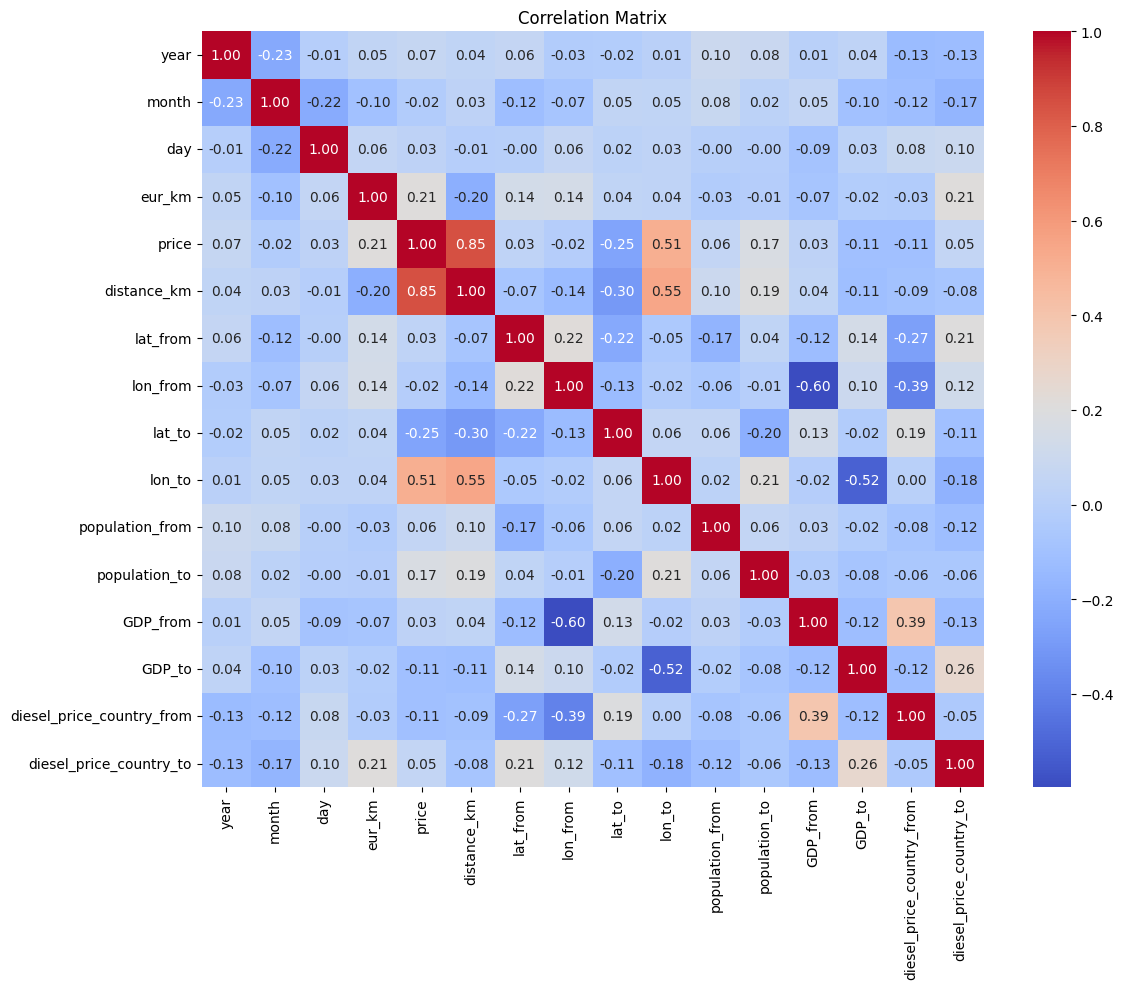

In [21]:
# Compute the correlation matrix for all numeric features.
numeric_cols = df_final.select_dtypes(include=[np.number])
correlation_matrix = numeric_cols.corr()

# Plot the correlation matrix.
plt.figure(figsize=(12, 10))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f")
plt.title('Correlation Matrix')
plt.tight_layout()
plt.show()

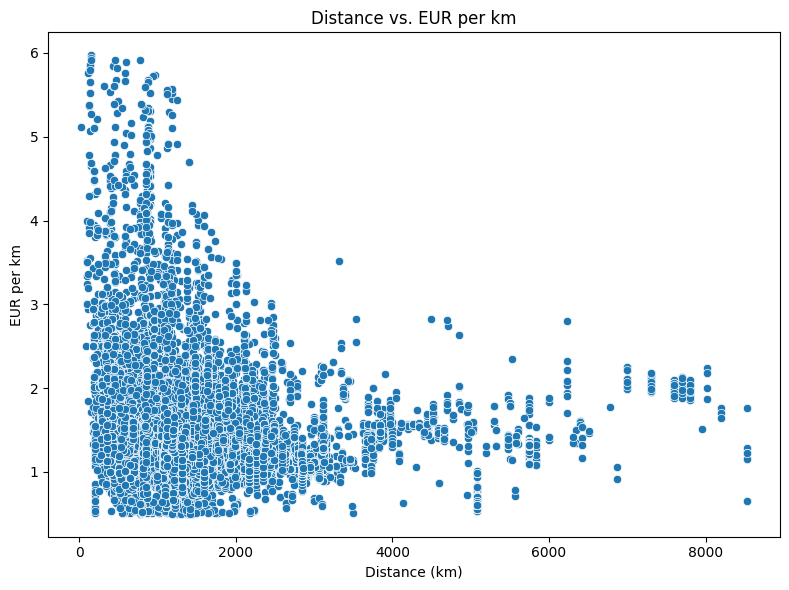

In [22]:
# Example scatter plot: relationship between distance and price per km.
plt.figure(figsize=(8, 6))
sns.scatterplot(x='distance_km', y='eur_km', data=df_final)
plt.title('Distance vs. EUR per km')
plt.xlabel('Distance (km)')
plt.ylabel('EUR per km')
plt.tight_layout()
plt.show()

In [23]:
# descriptive statistics
print("Descriptive statistics:")
print(df_final.describe())

Descriptive statistics:
               year         month           day        eur_km         price  \
count  28427.000000  28427.000000  28427.000000  28427.000000  28427.000000   
mean    2023.420410      6.125831     16.770781      1.483038   2219.277663   
std        0.641575      4.113209      9.258688      0.626822   1601.405543   
min     2021.000000      1.000000      1.000000      0.500664    104.864200   
25%     2023.000000      2.000000      9.000000      1.142857   1400.000000   
50%     2023.000000      6.000000     16.000000      1.344538   1800.000000   
75%     2024.000000     10.000000     26.000000      1.602055   2650.000000   
max     2024.000000     12.000000     31.000000      5.972368  18000.000000   

        distance_km      lat_from      lon_from        lat_to        lon_to  \
count  28427.000000  28427.000000  28427.000000  28427.000000  28427.000000   
mean    1584.741259     49.491450     14.395231     48.688868     19.019338   
std     1027.180172      3.

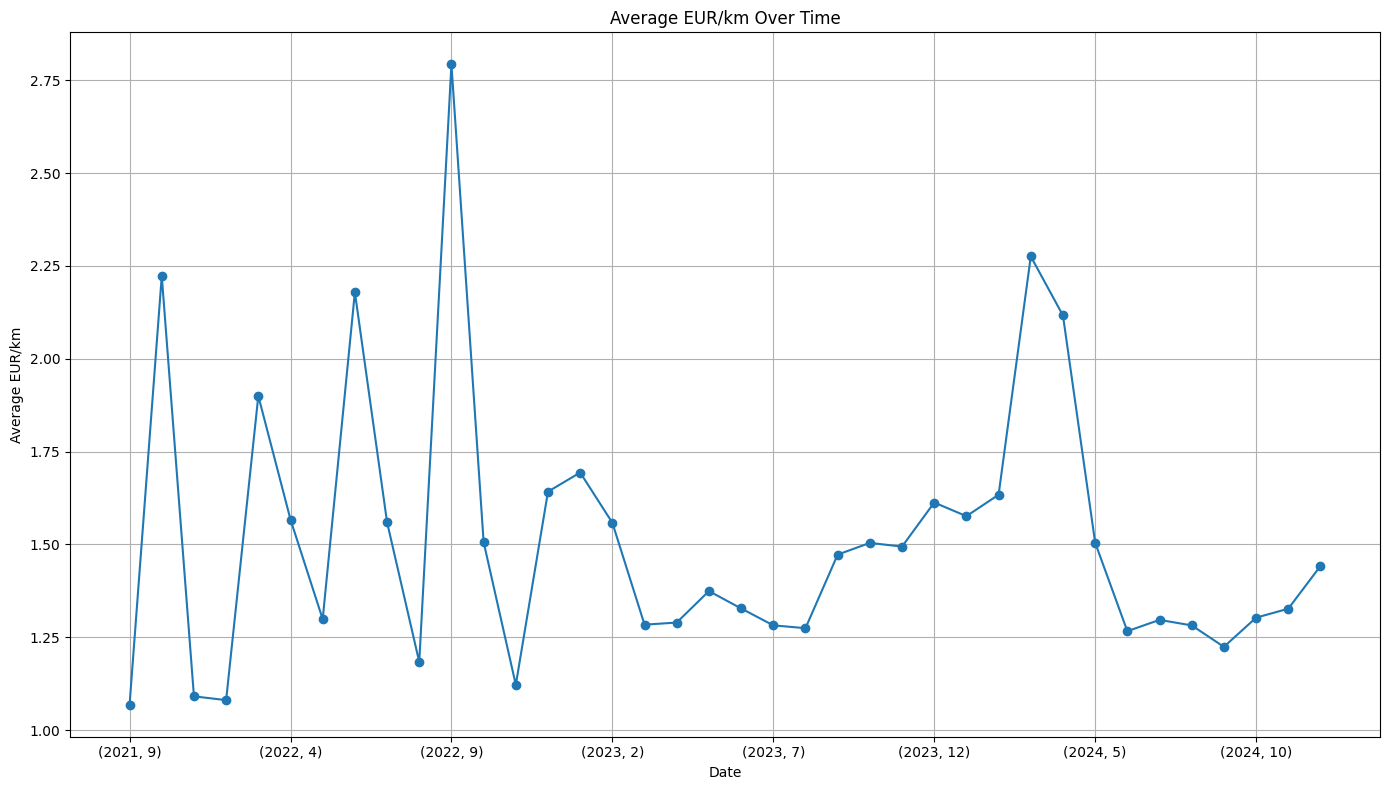

In [24]:
# Plot average eur/km over time
avg_eur_km = df_final.groupby(['year', 'month'])['eur_km'].mean()

plt.figure(figsize=(14, 8))
avg_eur_km.plot(marker='o')
plt.title('Average EUR/km Over Time')
plt.xlabel('Date')
plt.ylabel('Average EUR/km')
plt.grid(True)
# plt.xticks(rotation=10)
plt.tight_layout()
plt.show()

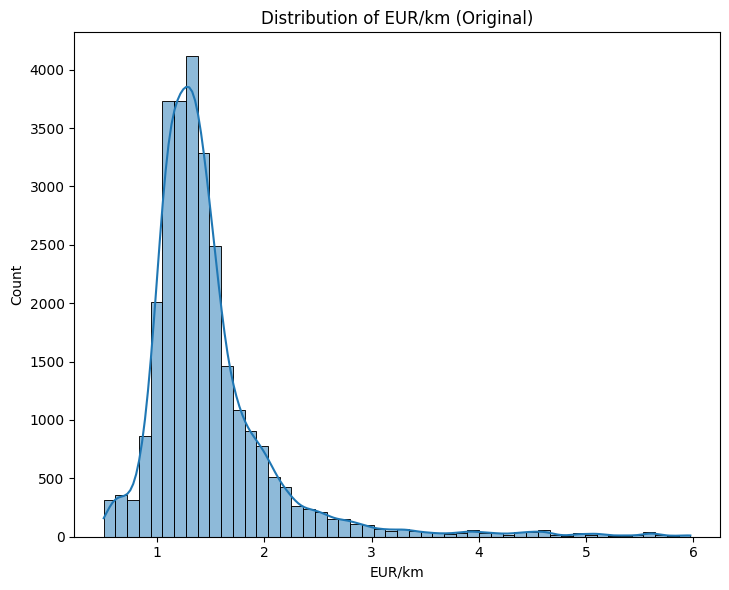

In [25]:
# ===============================
# Distribution plots of eur/km
# ===============================
plt.figure(figsize=(14, 6))

# Original EUR/km
plt.subplot(1, 2, 1)
sns.histplot(df_final['eur_km'], kde=True, bins=50)
plt.title('Distribution of EUR/km (Original)')
plt.xlabel('EUR/km')

# # Normalized EUR/km
# plt.subplot(1, 2, 2)
# sns.histplot(df_ts['eur_km'], kde=True, bins=50)
# plt.title('Distribution of EUR/km (Normalized)')
# plt.xlabel('Normalized EUR/km')

plt.tight_layout()
plt.show()

# Experiments

In [28]:
df_final

,year,month,day,is_weekend,eur_km,price,distance_km,lat_from,lon_from,lat_to,...,city_to=zborowo,city_to=zdunska wola,city_to=zhezdy,city_to=zhukivtsi,city_to=zielona gora,city_to=zoeterwoude-rijndijk,city_to=zwenkau,city_to=zwickau,city_to=zywiec,route
0,2021,9,2,False,1.220472,1550.0,1270.0,50.147721,15.641046,50.451359,...,False,False,False,False,False,False,False,False,False,dobrenice -> stoyanka
1,2021,9,2,False,0.946429,2650.0,2800.0,53.248236,-3.135770,50.451359,...,False,False,False,False,False,False,False,False,False,flint -> stoyanka
2,2021,9,2,False,0.896552,2600.0,2900.0,53.653511,-2.632596,50.451359,...,False,False,False,False,False,False,False,False,False,chorley -> stoyanka
3,2021,9,2,False,0.931034,2700.0,2900.0,53.653511,-2.632596,50.451359,...,False,False,False,False,False,False,False,False,False,chorley -> stoyanka
4,2021,9,2,False,0.879310,2550.0,2900.0,53.653511,-2.632596,50.451359,...,False,False,False,False,False,False,False,False,False,chorley -> stoyanka
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
28422,2024,12,27,False,1.209150,1850.0,1530.0,52.229676,21.012229,45.468503,...,False,False,False,False,False,False,False,False,False,warsaw -> milan
28423,2024,12,27,False,1.209399,1750.0,1447.0,45.057614,7.681092,50.064650,...,False,False,False,False,False,False,False,False,False,turin -> krakow
28424,2024,12,27,False,1.209399,1750.0,1447.0,45.057614,7.681092,50.064650,...,False,False,False,False,False,False,False,False,False,turin -> krakow
28425,2024,12,27,False,1.174845,1700.0,1447.0,45.057614,7.681092,50.064650,...,False,False,False,False,False,False,False,False,False,turin -> krakow


In [29]:
df1 = df_final[df_final.isna().any(axis=1)]
df1.values

array([], shape=(0, 1461), dtype=object)

## With exogenous factors

### Baseline

### Dataset and training

In [31]:
# Base features: distance and temporal features.
base_features = ['distance_km', 'year', 'month', 'day', 'is_weekend']

# New exogenous features:
exogenous_features = ['population_from', 'population_to', 'GDP_from', 'GDP_to', 'diesel_price_country_from', 'diesel_price_country_to']

# One-hot encoded transport type columns:
transport_cols = [col for col in df_final.columns if col.startswith('validated_transport_type=')]

# One-hot encoded location columns (if desired – note that these can be very high-dimensional)
location_cols = [col for col in df_final.columns if (col.startswith('country_from=') or
                                                 col.startswith('country_to=') or
                                                 col.startswith('city_from=') or
                                                 col.startswith('city_to='))]

# Combine all features into one list:
features = base_features + exogenous_features + transport_cols + location_cols

In [32]:
# Baseline
df_train, df_test = train_test_split(
    df_final,
    test_size=0.2,
    random_state=42
)

# train your baseline on TRAIN only (per-route mean) ---
route_avg    = df_train.groupby('route')['eur_km'].mean()
overall_mean = df_train['eur_km'].mean()

df_train['baseline_pred'] = df_train['route'].map(route_avg)
df_test ['baseline_pred'] = df_test ['route'].map(route_avg).fillna(overall_mean)

# now pull out X & y for modeling ---
X_train = df_train[features]
y_train = df_train['eur_km']
X_test  = df_test [features]
y_test  = df_test ['eur_km']

In [33]:
# Prepare X (features) and y (target)
X = df_final[features]
y = df_final['eur_km']

# split into Train and Test Sets
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

numeric_cols = [
    'distance_km','year','month','day',
    # 'lat_from','lon_from','lat_to','lon_to',
    'population_from','population_to',
    'GDP_from','GDP_to',
    'diesel_price_country_from','diesel_price_country_to'
]

scaler = StandardScaler()
# fit only on train
X_train[numeric_cols] = scaler.fit_transform(X_train[numeric_cols])
# apply same transform on test
X_test[numeric_cols]  = scaler.transform(X_test[numeric_cols])

In [34]:
# split into Train and Test Sets
# X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [35]:
# X_train.shape

#### Linear Regression

In [36]:
lr = LinearRegression()
lr.fit(X_train, y_train)
lr_preds_init = lr.predict(X_test)

#### Ridge regressor

In [ ]:
ridge_cv = RidgeCV()
ridge_cv.fit(X_train, y_train)
ridge_preds_init = ridge_cv.predict(X_test)

#### Random Forest Regressor

In [ ]:
rf = RandomForestRegressor(random_state=42)
rf.fit(X_train, y_train)
rf_preds_init = rf.predict(X_test)

#### XGBoost

In [ ]:
xgb = XGBRegressor(random_state=42)
xgb.fit(X_train, y_train)
xgb_preds_init = xgb.predict(X_test)

#### CatBoost

In [ ]:
cat = CatBoostRegressor(random_seed=42, verbose=0)
cat.fit(X_train, y_train)
cat_preds_init = cat.predict(X_test)

### Model evaluations

In [37]:
def evaluate_model(name, y_true, y_pred):
  mse = mean_squared_error(y_true, y_pred)
  rmse = np.sqrt(mse)
  mae  = mean_absolute_error(y_true, y_pred)
  mape = mean_absolute_percentage_error(y_true, y_pred)
  r2   = r2_score(y_true, y_pred)
  print(f"Model: {name}")
  print(f"  MSE: {mse:.4f}")
  print(f"  RMSE: {rmse:.4f}")
  print(f"  MAE: {mae:.4f}")
  print(f"  MAPE: {mape*100:.2f}%")
  print(f"  R²: {r2:.4f}")
  print("-----")

In [38]:
print("Baseline Evaluation:")
evaluate_model("Baseline", y_test, df_test['baseline_pred'])

Baseline Evaluation:
Model: Baseline
  MSE: 0.1306
  RMSE: 0.3614
  MAE: 0.1915
  MAPE: 12.75%
  R²: 0.6716
-----


In [39]:
# # Evaluate Baseline model
# if 'baseline_prediction' in df_final.columns:
#     baseline_preds = df_final.loc[X_test.index, 'baseline_prediction']
#     print("Baseline Model Evaluation:")
#     evaluate_model("Baseline", y_test, baseline_preds)

In [40]:
print("Linear Regression Evaluation:")
evaluate_model("Linear Regression", y_test, lr_preds_init)

Linear Regression Evaluation:
Model: Linear Regression
  MSE: 0.2046
  RMSE: 0.4523
  MAE: 0.2456
  MAPE: 16.62%
  R²: 0.4854
-----


In [ ]:
print("Ridge Regression Evaluation before Hyperparameter Tuning:")
evaluate_model(f"Ridge (α={ridge_cv.alpha_:.4f})", y_test, ridge_preds_init)

Ridge Regression Evaluation before Hyperparameter Tuning:
Model: Ridge (α=1.0000)
  MSE: 0.1617
  RMSE: 0.4022
  MAE: 0.2385
  R²: 0.5932
-----


In [ ]:
print("Random Forest Evaluation before Hyperparameter Tuning:")
evaluate_model("Random Forest", y_test, rf_preds_init)

Random Forest Evaluation before Hyperparameter Tuning:
Model: Random Forest
  MSE: 0.0435
  RMSE: 0.2087
  MAE: 0.0970
  R²: 0.8905
-----


In [ ]:
print("XGBoost Evaluation before Hyperparameter Tuning:")
evaluate_model("XGBoost", y_test, xgb_preds_init)

XGBoost Evaluation before Hyperparameter Tuning:
Model: XGBoost
  MSE: 0.0591
  RMSE: 0.2431
  MAE: 0.1419
  R²: 0.8514
-----


In [ ]:
print("CatBoost Evaluation before Hyperparameter Tuning:")
evaluate_model("CatBoost", y_test, cat_preds_init)

CatBoost Evaluation before Hyperparameter Tuning:
Model: CatBoost
  MSE: 0.0581
  RMSE: 0.2411
  MAE: 0.1470
  R²: 0.8537
-----


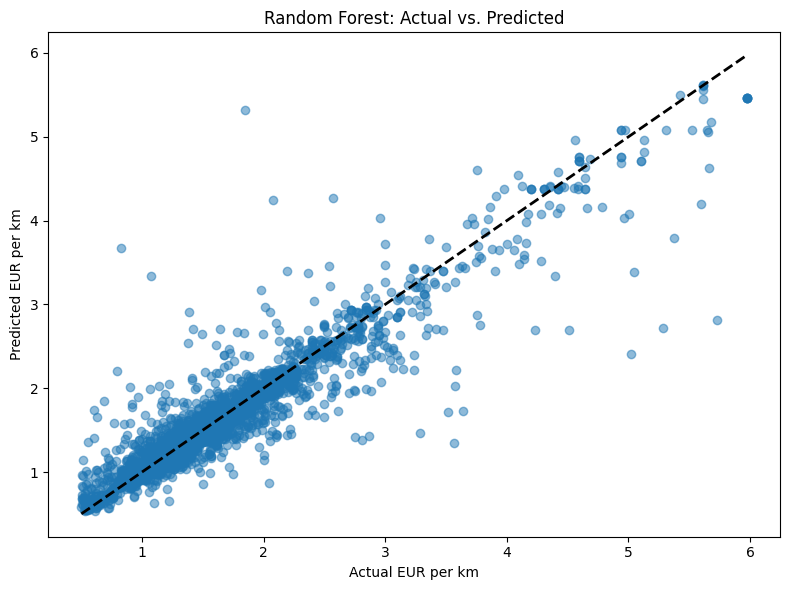

In [ ]:
# Plotting the Random Forest predictions versus the true values.
plt.figure(figsize=(8, 6))
plt.scatter(y_test, rf_preds_init, alpha=0.5)
plt.xlabel("Actual EUR per km")
plt.ylabel("Predicted EUR per km")
plt.title("Random Forest: Actual vs. Predicted")
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'k--', lw=2)
plt.tight_layout()
plt.show()

# Hypertuning

## Defining methods

In [41]:
@dataclass
class Dataset:
    train: pd.DataFrame
    val: pd.DataFrame
    test: pd.DataFrame

# --- Loss factories for hyperopt (to minimize) ---
def create_mse(actual_col, prediction_col):
    def calc_mse(actual, prediction):
        return mean_squared_error(actual[actual_col], prediction[prediction_col])
    return calc_mse

def create_mae(actual_col, prediction_col):
    def calc_mae(actual, prediction):
        return mean_absolute_error(actual[actual_col], prediction[prediction_col])
    return calc_mae

def create_rmse(actual_col, prediction_col):
    def calc_rmse(actual, prediction):
        return np.sqrt(mean_squared_error(actual[actual_col], prediction[prediction_col]))
    return calc_rmse

# --- Combined metrics for reporting ---
def create_all_metrics(actual_col, prediction_col):
    def all_metrics(actual, prediction):
        y_true = actual[actual_col]
        y_pred = prediction[prediction_col]
        mse  = mean_squared_error(y_true, y_pred)
        mae  = mean_absolute_error(y_true, y_pred)
        rmse = np.sqrt(mse)
        r2   = r2_score(y_true, y_pred)
        return {
            'mse':  np.round(mse,  4),
            'mae':  np.round(mae,  4),
            'rmse': np.round(rmse, 4),
            'r2':   np.round(r2,   4)
        }
    return all_metrics

# --- Regressor wrappers ---
class XGBoostRegressorHypertuning:
    def __init__(self, **kwargs):
        self.target_col = None
        self.model = XGBRegressor(**kwargs)

    def fit(self, train: pd.DataFrame, target_col: str):
        self.target_col = target_col
        X = train.drop(columns=[target_col])
        y = train[target_col]
        self.model.fit(X, y)

    def predict(self, x: pd.DataFrame) -> pd.DataFrame:
        X = x.drop(columns=[self.target_col])
        preds = self.model.predict(X)
        result = x.copy()
        result[f"{self.target_col}_hat"] = preds
        return result


class RandomForestRegressorHypertuning:
    def __init__(self, **kwargs):
        self.target_col = None
        self.model = RandomForestRegressor(**kwargs)

    def fit(self, train: pd.DataFrame, target_col: str):
        self.target_col = target_col
        X = train.drop(columns=[target_col])
        y = train[target_col]
        self.model.fit(X, y)

    def predict(self, x: pd.DataFrame) -> pd.DataFrame:
        X = x.drop(columns=[self.target_col])
        preds = self.model.predict(X)
        result = x.copy()
        result[f"{self.target_col}_hat"] = preds
        return result


class CatBoostRegressorHypertuning:
    def __init__(self, **kwargs):
        self.target_col = None
        # silence CatBoost’s own logging
        self.model = CatBoostRegressor(**kwargs, verbose=0)

    def fit(self, train: pd.DataFrame, target_col: str):
        self.target_col = target_col
        X = train.drop(columns=[target_col])
        y = train[target_col]
        self.model.fit(X, y)
        return self

    def predict(self, x: pd.DataFrame) -> pd.DataFrame:
        X = x.drop(columns=[self.target_col])
        preds = self.model.predict(X)
        out = x.copy()
        out[f"{self.target_col}_hat"] = preds
        return out


class RidgeHypertuning:
    def __init__(self, **kwargs):
        self.target_col = None
        self.model = Ridge(**kwargs)
    def fit(self, train: pd.DataFrame, target_col: str):
        self.target_col = target_col
        X = train.drop(columns=[target_col])
        y = train[target_col]
        self.model.fit(X, y)
    def predict(self, x: pd.DataFrame) -> pd.DataFrame:
        X = x.drop(columns=[self.target_col])
        preds = self.model.predict(X)
        out = x.copy()
        out[f"{self.target_col}_hat"] = preds
        return out

# --- Hyperopt tuner adapted for regression ---
class HypertunningRegressor:
    def __init__(self, base_estimator, verbose=True, finally_train=False):
        self.verbose = verbose
        self.base_estimator = base_estimator
        self.loss_fns = {
            "mse":  create_mse,
            "mae":  create_mae,
            "rmse": create_rmse
        }
        self.target_col = None
        self.params = None
        self.model = None
        self.results = {}
        self.optimization_cache = {}
        self.finally_train = finally_train

    def _clear_cache(self):
        self.optimization_cache = {}

    def fit(self, train: pd.DataFrame, target_col: str, hp: dict):
        self.target_col = target_col
        model = self.base_estimator(**hp)
        model.fit(train, target_col)
        return model

    def _tune(self, train, test, loss_fn, metrics_fn):
        cache = self.optimization_cache
        def objective(hp):
            key = hash(json.dumps(hp, sort_keys=True))
            if key in cache:
                return cache[key]

            model = self.fit(train, self.target_col, hp)
            preds_df = model.predict(test)
            loss = loss_fn(test, preds_df)
            metrics = metrics_fn(test, preds_df) if metrics_fn else None

            result = {
                'loss': loss,
                'status': STATUS_OK,
                'meta': {
                    'model': model,
                    'params': hp,
                    'forecast': {
                        'dataframe': preds_df,
                        'metrics': metrics
                    }
                }
            }
            cache[key] = result
            return result
        return objective

    def fit_tune(self,
                 data: Dataset,
                 target_col: str,
                 hyperopt_space: dict,
                 loss: str = "mse",
                 max_evals: int = 30):
        self.target_col = target_col

        loss_fn    = self.loss_fns[loss](target_col, f"{target_col}_hat")
        metrics_fn = create_all_metrics(target_col, f"{target_col}_hat")

        # 1) Tune on validation
        trials = Trials()
        self._clear_cache()
        best = fmin(fn    = self._tune(data.train, data.val, loss_fn, metrics_fn),
                    space = hyperopt_space,
                    algo  = tpe.suggest,
                    max_evals = max_evals,
                    trials = trials)

        self.params = trials.best_trial['result']['meta']['params']
        self.results['validation'] = trials.best_trial['result']

        # 2) Evaluate on test
        combined = pd.concat([data.train, data.val])
        self._clear_cache()
        test_res = self._tune(combined, data.test, loss_fn, metrics_fn)(self.params)
        self.results['test'] = test_res

        # 3) (Optional) retrain on all data
        if self.finally_train:
            self.model = self.fit(pd.concat([combined, data.test]), target_col, self.params)
            return {'model': self.model, 'results': self.results}
        else:
            return {'results': self.results}


## models

In [42]:
final_df = pd.concat([X, y], axis=1)

In [43]:
final_df_test = pd.concat([X, y], axis=1)

In [44]:
random_state = 42
train, test = train_test_split(final_df, test_size=0.15, random_state=random_state)
train, val = train_test_split(train, test_size=0.15, random_state=random_state)

In [45]:
numeric_cols = [
    'distance_km','year','month','day',
    'population_from','population_to',
    'GDP_from','GDP_to',
    'diesel_price_country_from','diesel_price_country_to'
]

scaler = StandardScaler()
# fit on train only
train[numeric_cols] = scaler.fit_transform(train[numeric_cols])

# transform val & test with the same scaler
val[numeric_cols] = scaler.transform(val[numeric_cols])
test[numeric_cols] = scaler.transform(test[numeric_cols])

splitted = Dataset(train=train, val=val, test=test)

In [46]:
splitted.train.shape

(20537, 1455)

In [47]:
splitted.val.shape

(3625, 1455)

In [48]:
splitted.test.shape

(4265, 1455)

### Ridge

In [ ]:
ridge_space = {
    'alpha': hp.loguniform('alpha', np.log(1e-3), np.log(1e2))
}

# instantiate the tuner
ridge_tuner = HypertunningRegressor(
    base_estimator=RidgeHypertuning
    # finally_train=True   # retrain on full train+val+test at the end
)

In [ ]:
#  run hypertuning
ridge_results = ridge_tuner.fit_tune(
    data           = splitted,
    target_col     = 'eur_km',
    hyperopt_space = ridge_space,
    loss           = 'mse',
    max_evals      = 100
)

100%|██████████| 100/100 [04:50<00:00,  2.91s/trial, best loss: 0.1404443109553917]


In [ ]:
print("Best α:", ridge_results['results']['validation']['meta']['params']['alpha'])
print("Validation metrics:", ridge_results['results']['validation']['meta']['forecast']['metrics'])
print("Test metrics:",       ridge_results['results']['test']['meta']['forecast']['metrics'])

Best α: 0.7619338573931674
Validation metrics: {'mse': np.float64(0.1404), 'mae': np.float64(0.2275), 'rmse': np.float64(0.3748), 'r2': np.float64(0.6354)}
Test metrics: {'mse': np.float64(0.168), 'mae': np.float64(0.2398), 'rmse': np.float64(0.4098), 'r2': np.float64(0.5998)}


Training on hyperparameter after tunning

In [49]:
best_params_ridge = {'alpha': 0.7619338573931674}

In [ ]:
# Reconstruct the best model and retrain on all labeled data
best_params_ridge = ridge_tuner.params

In [50]:
best_params_ridge

{'alpha': 0.7619338573931674}

In [51]:
# Wrap and retrain
ridge_final = RidgeHypertuning(**best_params_ridge)
train_val = pd.concat([splitted.train, splitted.val], ignore_index=True)
ridge_final.fit(train_val, target_col='eur_km')

ridge_preds = ridge_final.predict(splitted.test)

In [52]:
print("Ridge tunned Evaluation:")
evaluate_model("Ridge", splitted.test['eur_km'], ridge_preds['eur_km_hat'])

Ridge tunned Evaluation:
Model: Ridge
  MSE: 0.1680
  RMSE: 0.4098
  MAE: 0.2398
  MAPE: 15.60%
  R²: 0.5998
-----


### XGBoost

In [ ]:
max_evals = 100
target_column = 'eur_km'

# Hyperparameters space
boosting_hyperopt_space = {
                          # 'tree_method': 'gpu_hist',
                          # 'gpu_id': 0,
                          'max_depth': hp.choice('max_depth', [3, 5, 6, 10, 15, 20, 25]),
                          'learning_rate': hp.choice('learning_rate', [0.01, 0.1, 0.2, 0.3]),
                          'subsample': hp.choice('subsample', [0.5, 0.6, 0.8, 1]),
                          'colsample_bytree': hp.choice('colsample_bytree', [0.4, 0.5, 0.8, 1]),
                          'colsample_bylevel': hp.choice('colsample_bylevel', [0.4, 0.5, 0.8, 0.1]),
                          'n_estimators': hp.choice('n_estimators', [20, 50, 80, 100, 150, 200, 300]),
                          'scale_pos_weight': hp.choice('scale_pos_weight', [1, 2, 3, 5, 10])
                          #  "objective": 'binary:logistic'
                           }

xgb_hyper = HypertunningRegressor(base_estimator=XGBoostRegressorHypertuning)

In [ ]:
xgb_hyper_results = xgb_hyper.fit_tune(splitted, target_col=target_column, max_evals=max_evals,
                                       hyperopt_space=boosting_hyperopt_space, loss = 'mse')

100%|██████████| 100/100 [19:27<00:00, 11.67s/trial, best loss: 0.03969896893417122]


In [ ]:
xgb_hyper_results['results']['validation']['meta']['forecast']['metrics']

{'mse': np.float64(0.0397),
 'mae': np.float64(0.0999),
 'rmse': np.float64(0.1992),
 'r2': np.float64(0.8969)}

In [ ]:
xgb_hyper_results['results']['test']['meta']['forecast']['metrics']

{'mse': np.float64(0.0462),
 'mae': np.float64(0.1021),
 'rmse': np.float64(0.2149),
 'r2': np.float64(0.89)}

Training on hyperparameter after tunning

In [53]:
best_params_xgb = {'colsample_bylevel': 0.4,
 'colsample_bytree': 0.8,
 'learning_rate': 0.2,
 'max_depth': 25,
 'n_estimators': 20,
 'scale_pos_weight': 10,
 'subsample': 0.8}

In [ ]:
# Reconstruct the best model and retrain on all labeled data
best_params_xgb = xgb_hyper.params

In [54]:
best_params_xgb

{'colsample_bylevel': 0.4,
 'colsample_bytree': 0.8,
 'learning_rate': 0.2,
 'max_depth': 25,
 'n_estimators': 20,
 'scale_pos_weight': 10,
 'subsample': 0.8}

In [55]:
# Wrap and retrain
xgb_final = XGBoostRegressorHypertuning(**best_params_xgb)
train_val = pd.concat([splitted.train, splitted.val], ignore_index=True)
xgb_final.fit(train_val, target_col='eur_km')

xgb_preds = xgb_final.predict(splitted.test)

In [56]:
print("XGBoost tunned Evaluation:")
evaluate_model("XGBoost", splitted.test['eur_km'], xgb_preds['eur_km_hat'])

XGBoost tunned Evaluation:
Model: XGBoost
  MSE: 0.0462
  RMSE: 0.2149
  MAE: 0.1021
  MAPE: 6.84%
  R²: 0.8900
-----


### Random Forest

In [ ]:
max_evals = 60
target_column = 'eur_km'

# Hyperparameters space
rf_hyperopt_space = {'bootstrap':  hp.choice('bootstrap', [True, False]),
                     'max_depth':  hp.choice('max_depth', [50, 60, 70, 80]),
                    #  'max_features':  hp.choice('max_features',['auto', 'sqrt']),
                     'min_samples_leaf':  hp.choice('min_samples_leaf', [1, 2, 4, 8]),
                     'min_samples_split':  hp.choice('min_samples_split', [2, 3, 4, 5, 6]),
                     'n_estimators':  hp.choice('n_estimators', [50, 100, 150, 200, 250, 300])}

rf_hyper = HypertunningRegressor(base_estimator=RandomForestRegressorHypertuning)

In [ ]:
rf_hyper_results = rf_hyper.fit_tune(splitted, target_col=target_column, max_evals=max_evals, hyperopt_space=rf_hyperopt_space, loss='mse')

100%|██████████| 60/60 [2:29:07<00:00, 149.13s/trial, best loss: 0.040060680951147974]


In [ ]:
rf_hyper_results['results']['validation']['meta']['forecast']['metrics']

{'mse': np.float64(0.0401),
 'mae': np.float64(0.0959),
 'rmse': np.float64(0.2002),
 'r2': np.float64(0.896)}

In [ ]:
rf_hyper_results['results']['test']['meta']['forecast']['metrics']

{'mse': np.float64(0.0449),
 'mae': np.float64(0.0966),
 'rmse': np.float64(0.2118),
 'r2': np.float64(0.8931)}

Retrain

In [57]:
best_params_rf = {'bootstrap': True,
 'max_depth': 50,
 'min_samples_leaf': 1,
 'min_samples_split': 3,
 'n_estimators': 300}

In [ ]:
# Reconstruct the best model and retrain on all labeled data
best_params_rf = rf_hyper.params

In [58]:
best_params_rf

{'bootstrap': True,
 'max_depth': 50,
 'min_samples_leaf': 1,
 'min_samples_split': 3,
 'n_estimators': 300}

In [59]:
# Wrap and retrain
rf_final = RandomForestRegressorHypertuning(**best_params_rf)
train_val = pd.concat([splitted.train, splitted.val], ignore_index=True)
rf_final.fit(train_val, target_col='eur_km')

rf_preds = rf_final.predict(splitted.test)

In [60]:
print("Random Forest tunned Evaluation:")
evaluate_model("Random Forest", splitted.test['eur_km'], rf_preds['eur_km_hat'])

Random Forest tunned Evaluation:
Model: Random Forest
  MSE: 0.0447
  RMSE: 0.2114
  MAE: 0.0967
  MAPE: 6.44%
  R²: 0.8935
-----


### CatBoost

In [ ]:
catboost_hyperopt_space = {
    'iterations':        hp.choice('iterations', [100, 150, 200, 250, 300]),
    'depth':             hp.choice('depth', [4, 6, 8, 10]),
    'learning_rate':     hp.loguniform('learning_rate', -5, -1),  # ~0.0067–0.37
    'l2_leaf_reg':       hp.choice('l2_leaf_reg', [1, 3, 5, 7, 9]),
    'bagging_temperature': hp.uniform('bagging_temp', 0.0, 1.0),
    'random_strength':   hp.uniform('random_strength', 0.0, 1.0),
    # you can add more: 'border_count', 'ctr_border_count', etc.
}

max_evals    = 100
target_column = 'eur_km'

cat_hyper = HypertunningRegressor(
    base_estimator=CatBoostRegressorHypertuning,
    verbose=True,
    finally_train=False
)

In [ ]:
cat_hyper_results = cat_hyper.fit_tune(
    data            = splitted,
    target_col      = target_column,
    hyperopt_space  = catboost_hyperopt_space,
    max_evals       = max_evals,
    loss            = "mse"
)

100%|██████████| 100/100 [21:53<00:00, 13.13s/trial, best loss: 0.042016291253712264]


In [ ]:
cat_hyper_results['results']['validation']['meta']['forecast']['metrics']

{'mse': np.float64(0.042),
 'mae': np.float64(0.1143),
 'rmse': np.float64(0.205),
 'r2': np.float64(0.8909)}

In [ ]:
cat_hyper_results['results']['test']['meta']['forecast']['metrics']

{'mse': np.float64(0.0467),
 'mae': np.float64(0.1162),
 'rmse': np.float64(0.2161),
 'r2': np.float64(0.8887)}

Retrain

In [61]:
best_params_cat = {'bagging_temperature': 0.10151082623257712,
 'depth': 10,
 'iterations': 250,
 'l2_leaf_reg': 1,
 'learning_rate': 0.30291452835400245,
 'random_strength': 0.6157853000997278}

In [ ]:
# Reconstruct the best model and retrain on all labeled data
best_params_cat = cat_hyper.params

In [62]:
best_params_cat

{'bagging_temperature': 0.10151082623257712,
 'depth': 10,
 'iterations': 250,
 'l2_leaf_reg': 1,
 'learning_rate': 0.30291452835400245,
 'random_strength': 0.6157853000997278}

In [63]:
# Wrap and retrain
cat_final = CatBoostRegressorHypertuning(**best_params_cat)
train_val = pd.concat([splitted.train, splitted.val], ignore_index=True)
cat_final.fit(train_val, target_col='eur_km')

cat_preds = cat_final.predict(splitted.test)

In [64]:
print("CatBoost tunned Evaluation:")
evaluate_model("CatBoost", splitted.test['eur_km'], cat_preds['eur_km_hat'])

CatBoost tunned Evaluation:
Model: CatBoost
  MSE: 0.0467
  RMSE: 0.2161
  MAE: 0.1162
  MAPE: 8.02%
  R²: 0.8887
-----


# SHAP analysis

In [ ]:
xgb_final
xgb_preds

In [99]:
print("XGBoost tunned Evaluation:")
evaluate_model("XGBoost", splitted.test['eur_km'], xgb_preds['eur_km_hat'])

XGBoost tunned Evaluation:
Model: XGBoost
  MSE: 0.0462
  RMSE: 0.2149
  MAE: 0.1021
  MAPE: 6.84%
  R²: 0.8900
-----


In [100]:
booster = xgb_final.model.get_booster()

explainer = shap.TreeExplainer(booster)

In [101]:
X_test = splitted.test.drop(columns=['eur_km'])

shap_values = explainer.shap_values(X_test)

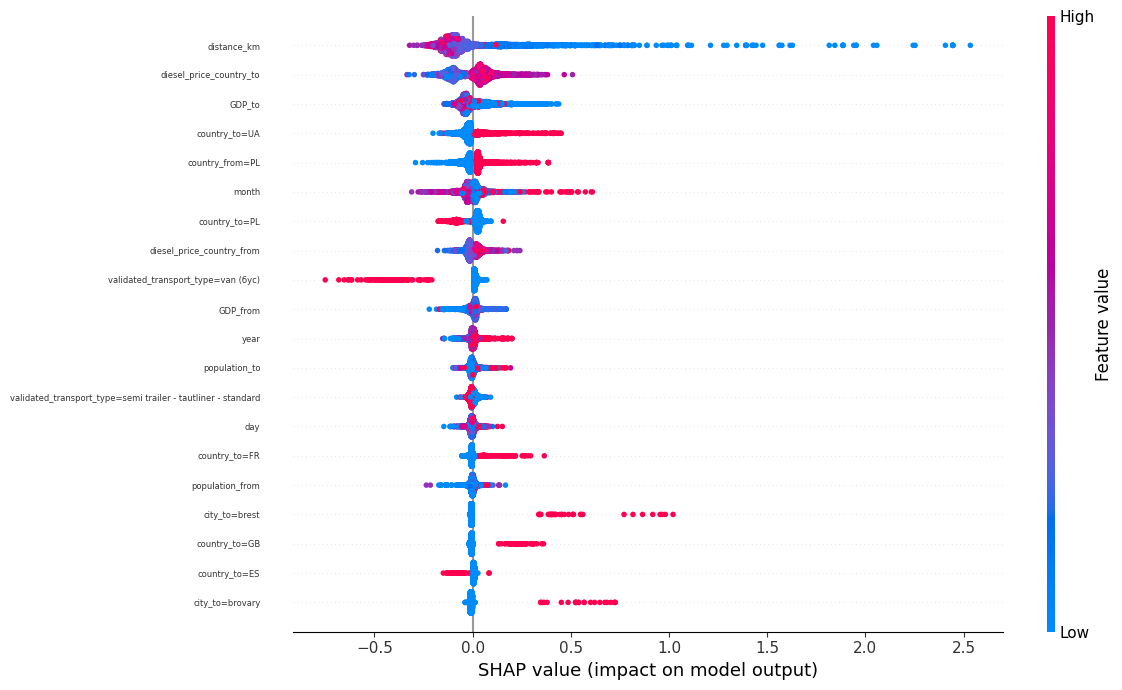

In [112]:
# 5) Global importance (dot + bar)
shap.summary_plot(
    shap_values,
    X_test,
    plot_type="dot",
    plot_size=(12, 7),
    show=False
)
ax = plt.gca()
ax.tick_params(axis='y', labelsize=6)

plt.tight_layout()
plt.show()

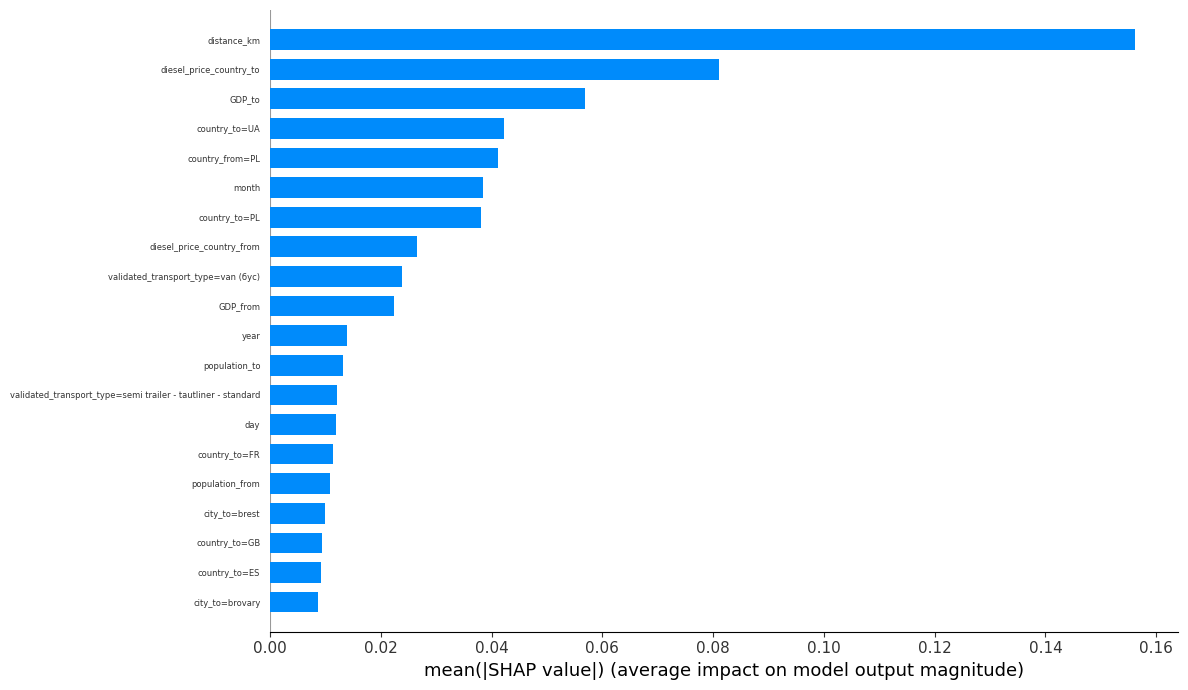

In [113]:
shap.summary_plot(
    shap_values,
    X_test,
    plot_type="bar",
    plot_size=(12, 7),                 # also informs SHAP of the target size
    show=False
)
ax = plt.gca()
ax.tick_params(axis='y', labelsize=6)

plt.tight_layout()
plt.show()

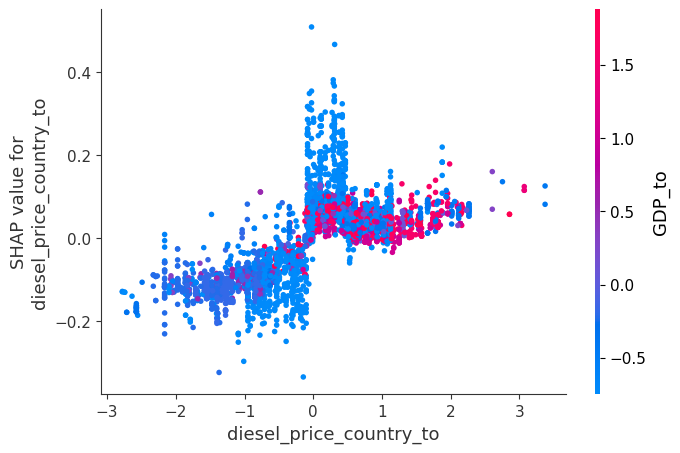

In [117]:
# 7) (Optional) Interaction plot example:
shap.dependence_plot(
    'diesel_price_country_to',
    shap_values,
    X_test,
    interaction_index='GDP_to'
)

# Testing on tenders dataset

In [65]:
numeric_cols

['distance_km',
 'year',
 'month',
 'day',
 'population_from',
 'population_to',
 'GDP_from',
 'GDP_to',
 'diesel_price_country_from',
 'diesel_price_country_to']

In [66]:
train_df = df_final.copy()
scaler = StandardScaler()
train_df.loc[:, numeric_cols] = scaler.fit_transform(train_df[numeric_cols])

X_comb = train_df[features]
y_comb = train_df['eur_km']

In [67]:
# Baseline: per-route mean
route_avg = train_df.groupby('route')['eur_km'].mean()
overall_mean = train_df['eur_km'].mean()

In [68]:
# Linear Regression
lr = LinearRegression().fit(X_comb, y_comb)

In [69]:
# Ridge
ridge = Ridge(**best_params_ridge).fit(X_comb, y_comb)

In [70]:
# Random Forest
rf = RandomForestRegressor(**best_params_rf, random_state=42).fit(X_comb, y_comb)

In [71]:
# XGBoost
xgb = XGBRegressor(**best_params_xgb).fit(X_comb, y_comb)

In [72]:
# CatBoost
cat = CatBoostRegressor(**best_params_cat, verbose=0).fit(X_comb, y_comb)

In [73]:
# prepare tender features
df_t = df_tenders_final.copy()
X_t  = df_t[features].copy()
X_t[numeric_cols] = scaler.transform(X_t[numeric_cols])

# define an evaluation loop with MAPE instead of R²
def evaluate(name, preds, baseline_wins=None):
    # attach preds + margin + win‐flag
    df_t[f"pred_{name}"]      = preds
    df_t[f"pred_{name}_marg"] = preds * 1.05
    df_t[f"win_{name}"]       = (
        np.abs(df_t[f"pred_{name}_marg"] - df_t['eur_km'])
        / df_t['eur_km'] <= 0.07
    ).astype(int)

    # regression metrics function (now includes MAPE)
    def reg_metrics(y_true, y_pred):
        mse  = mean_squared_error(y_true, y_pred)
        mae  = mean_absolute_error(y_true, y_pred)
        rmse = np.sqrt(mse)
        mape = np.mean(np.abs((y_true - y_pred) / y_true)) * 100
        return mse, mae, rmse, mape

    # Full-set metrics
    y_true_full = df_t['eur_km']
    y_pred_full = preds
    mse, mae, rmse, mape = reg_metrics(y_true_full, y_pred_full)
    print(f"{name.upper():<10} FULL → MSE {mse:.4f}, MAE {mae:.4f}, RMSE {rmse:.4f}, MAPE {mape:.1f}%")

    # Win-only subset metrics
    win_idx = df_t['status']=="Win"
    y_true_w = df_t.loc[win_idx, 'eur_km']
    y_pred_w = preds[win_idx]
    mse, mae, rmse, mape = reg_metrics(y_true_w, y_pred_w)
    print(f"{name.upper():<10} WIN  → MSE {mse:.4f}, MAE {mae:.4f}, RMSE {rmse:.4f}, MAPE {mape:.1f}%")

    # Win counts and rates
    wins             = df_t[f"win_{name}"].sum()
    total_actual_wins = (df_t['status']=="Win").sum()
    win_pct          = wins / total_actual_wins * 100
    print(f"{name.upper():<10} WINS → {wins}/{total_actual_wins} = {win_pct:.1f}%")

    # Compare to baseline
    if baseline_wins is not None:
        rel_ratio = wins / baseline_wins * 100
        print(f"{name.upper():<10} VS_BSL → {wins}/{baseline_wins} = {rel_ratio:.1f}%")

    print()

In [74]:
# baseline first, capture its wins
pred_baseline = df_t['route'].map(route_avg).fillna(overall_mean).values
evaluate('baseline', pred_baseline)
baseline_wins = df_t['win_baseline'].sum()

BASELINE   FULL → MSE 0.4606, MAE 0.5368, RMSE 0.6787, MAPE 56.4%
BASELINE   WIN  → MSE 0.7799, MAE 0.5928, RMSE 0.8831, MAPE 39.0%
BASELINE   WINS → 73/58 = 125.9%



In [75]:
# now each model, passing baseline_wins
evaluate('linear', lr.predict(X_t), baseline_wins)
evaluate('ridge',  ridge.predict(X_t), baseline_wins)
evaluate('rf',     rf.predict(X_t),    baseline_wins)
evaluate('xgb',    xgb.predict(X_t),   baseline_wins)
evaluate('cat',    cat.predict(X_t),   baseline_wins)

LINEAR     FULL → MSE 0.5720, MAE 0.5776, RMSE 0.7563, MAPE 60.0%
LINEAR     WIN  → MSE 0.8176, MAE 0.6493, RMSE 0.9042, MAPE 41.9%
LINEAR     WINS → 111/58 = 191.4%
LINEAR     VS_BSL → 111/73 = 152.1%

RIDGE      FULL → MSE 0.4525, MAE 0.5185, RMSE 0.6727, MAPE 54.5%
RIDGE      WIN  → MSE 0.8287, MAE 0.6542, RMSE 0.9103, MAPE 42.4%
RIDGE      WINS → 101/58 = 174.1%
RIDGE      VS_BSL → 101/73 = 138.4%

RF         FULL → MSE 0.5056, MAE 0.5566, RMSE 0.7111, MAPE 57.5%
RF         WIN  → MSE 0.4054, MAE 0.3947, RMSE 0.6367, MAPE 22.2%
RF         WINS → 58/58 = 100.0%
RF         VS_BSL → 58/73 = 79.5%

XGB        FULL → MSE 0.4414, MAE 0.5370, RMSE 0.6644, MAPE 56.5%
XGB        WIN  → MSE 0.3954, MAE 0.4682, RMSE 0.6288, MAPE 31.1%
XGB        WINS → 62/58 = 106.9%
XGB        VS_BSL → 62/73 = 84.9%

CAT        FULL → MSE 0.4787, MAE 0.5659, RMSE 0.6919, MAPE 60.0%
CAT        WIN  → MSE 0.3448, MAE 0.4402, RMSE 0.5872, MAPE 29.6%
CAT        WINS → 66/58 = 113.8%
CAT        VS_BSL → 66/73 = 9